In [15]:
import random
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2

## Data loading

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
data_path = '/content/gdrive/MyDrive/dataCS433'

In [18]:
#TODO CREATE AN APPROPRIATE DATALOADER
whole_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.1, 0.1,0.1],
            std= [0.2133, 0.2133, 0.2133])
        ])
)

In [ ]:
train_indices, val_indices = train_test_split(whole_dataset.targets, test_size=0.5, stratify=whole_dataset.targets, random_state=42)
train_dataset = Subset(whole_dataset,train_indices)
val_dataset = Subset(whole_dataset,val_indices)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    num_workers=1,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False
)

In [ ]:
def display_image(image):
  image_np = image.numpy()
  img_plt = image_np.transpose(1,2,0)
  plt.imshow(img_plt)

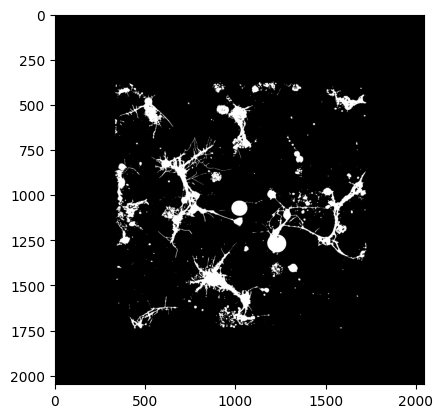

In [ ]:
display_image(train_dataset[1][0])

## Data augmentation

The idea is that we have a class that allows to generate custom datasets, from the training set we already defined. Thus, during training, after each epoch we will draw a new train dataset/dataloader, derived from the original train set. This works if we use random transformations. Indeed, more epochs on randomly selected datasets is equivalent less epochs on a randomly extended dataset.

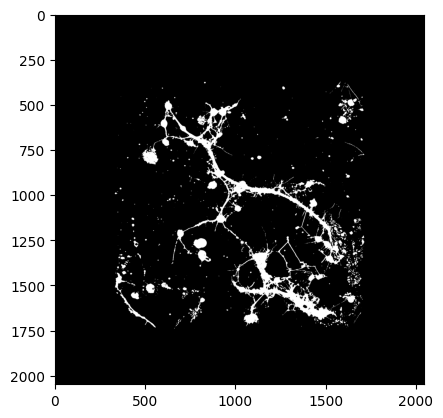

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

#Example
transformed_dataset = CustomDataset(train_dataset, transform=transforms.Compose([
                v2.ToTensor(),
                v2.RandomHorizontalFlip(1)
            ]))

display_image(transformed_dataset[0][0])

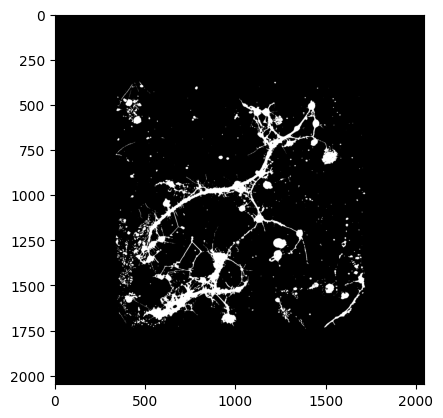

In [ ]:
display_image(train_dataset[0][0])

## Model

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3,32,5,1,2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32,64,5,2,2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64,64,5,1,2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64,128,5,2,2),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(1),
    torch.nn.Conv2d(128,2,1),
    torch.nn.Flatten()
)


In [ ]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()
    loss_history = []
    accuracy_history = []
    lr_history = []
    for batch_idx, (data,target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        loss_float = loss.item()
        accuracy_float = correct / len(data)

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        lr_history.append(scheduler.get_last_lr()[0])
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, accuracy_history, lr_history


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)
        pred = output.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(val_loader.dataset),
            100.0 * correct / len(val_loader.dataset),
        )
    )
    return test_loss, correct / len(val_loader.dataset)


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        pred = output.argmax(dim=1, keepdim=True)

        data = np.split(data.cpu().numpy(), len(data))
        loss = np.split(loss.cpu().numpy(), len(data))
        pred = np.split(pred.cpu().numpy(), len(data))
        target = np.split(target.cpu().numpy(), len(data))
        points.extend(zip(data, loss, pred, target))

        if num is not None and len(points) > num:
            break

    return points


def run_training(
    model,
    num_epochs,
    optimizer_kwargs,
    train_loader,
    val_loader,
    device="cuda"
):

    # ===== Model, Optimizer and Criterion =====
    model = model.to(device=device)
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    criterion = torch.nn.functional.cross_entropy
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, lrs = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        lr_history.extend(lrs)

        val_loss, val_acc = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

    # ===== Plot training curves =====
    n_train = len(train_acc_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(6.4 * 3, 4.8))
    plt.subplot(1, 3, 1)
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(1, 3, 2)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 3)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")

    # ===== Plot low/high loss predictions on validation set =====
    points = get_predictions(
        model,
        device,
        val_loader,
        partial(torch.nn.functional.cross_entropy, reduction="none"),
    )
    points.sort(key=lambda x: x[1])
    plt.figure(figsize=(15, 6))
    for k in range(5):
        plt.subplot(2, 5, k + 1)
        plt.imshow(points[k][0][0, 0], cmap="gray")
        plt.title(f"true={int(points[k][3])} pred={int(points[k][2])}")
        plt.subplot(2, 5, 5 + k + 1)
        plt.imshow(points[-k - 1][0][0, 0], cmap="gray")
        plt.title(f"true={int(points[-k-1][3])} pred={int(points[-k-1][2])}")

    return sum(train_acc) / len(train_acc), val_acc

In [ ]:
num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict(
    lr=1e-3,
    weight_decay=1e-2,
)

run_training(
    model=model,
    num_epochs=num_epochs,
    optimizer_kwargs=optimizer_kwargs,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

ZeroDivisionError: ignored